In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [3]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [4]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 118.5 GB  | Proc size: 515.5 MB
GPU RAM Free: 15324MB | Used: 846MB | Util   5% | Total 16376MB


In [5]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))]
    )
    trainset = FashionMNIST("./dataset", train=True, download=True, transform=transform)
    testset = FashionMNIST("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [8]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [9]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [10]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 17:56:43,594	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 72664203060.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 35427515596.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5236) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 28.828376293182373and 2habhhahah
this is tehb mode time [28.83]
This is ths last time not a fantasy 28.305307626724243and 9habhhahah
this is tehb mode time [28.83, 28.31]
This is ths last time not a fantasy 26.18410611152649and 7habhhahah
this is tehb mode time [28.83, 28.31, 26.18]
This is ths last time not a fantasy 25.976600646972656and 6habhhahah
this is tehb mode time [28.83, 28.31, 26.18, 25.98]
This is ths last time not a fantasy 25.296934843063354and 8habhhahah
this is tehb mode time [28.83, 28.31, 26.18, 25.98, 25.3]
This is ths last time not a fantasy 25.87026357650757and 3habhhahah
this is tehb mode time [28.83, 28.31, 26.18, 25.98, 25.3, 25.87]
This is ths last time not a fantasy 25.584823608398438and 5habhhahah
this is tehb mode time [28.83, 28.31, 26.18, 25.98, 25.3, 25.87, 25.58]
This is ths last time not a fantasy 25.270262241363525and 4habhhahah
this is tehb mode time [28.83, 28.31, 26.18, 25.98, 25.3, 25.87, 25.58, 25.27]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29968) Training time for Client 1: 26.30 seconds
(ClientAppActor pid=29968) Epoch 8: train loss 0.007065, accuracy 0.914444 [repeated 4x across cluster]
(ClientAppActor pid=39696) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.7151460647583and 4habhhahah
this is tehb mode time [22.72]
This is ths last time not a fantasy 22.931145429611206and 6habhhahah
this is tehb mode time [22.72, 22.93]
This is ths last time not a fantasy 22.49114441871643and 7habhhahah
this is tehb mode time [22.72, 22.93, 22.49]
This is ths last time not a fantasy 23.0731463432312and 9habhhahah
this is tehb mode time [22.72, 22.93, 22.49, 23.07]
This is ths last time not a fantasy 23.04414415359497and 5habhhahah
this is tehb mode time [22.72, 22.93, 22.49, 23.07, 23.04]
This is ths last time not a fantasy 22.91314458847046and 2habhhahah
this is tehb mode time [22.72, 22.93, 22.49, 23.07, 23.04, 22.91]
This is ths last time not a fantasy 26.295614004135132and 1habhhahah
this is tehb mode time [22.72, 22.93, 22.49, 23.07, 23.04, 22.91, 26.3]
This is ths last time not a fantasy 22.782143592834473and 8habhhahah
this is tehb mode time [22.72, 22.93, 22.49, 23.07, 23.04, 22.91, 26.3, 22.78]
This is ths l

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29968) Training time for Client 3: 26.10 seconds
(ClientAppActor pid=29968) Epoch 8: train loss 0.005138, accuracy 0.937222 [repeated 4x across cluster]
(ClientAppActor pid=33364) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.807072639465332and 8habhhahah
this is tehb mode time [22.81]
This is ths last time not a fantasy 26.095205068588257and 3habhhahah
this is tehb mode time [22.81, 26.1]
This is ths last time not a fantasy 23.112510919570923and 9habhhahah
this is tehb mode time [22.81, 26.1, 23.11]
This is ths last time not a fantasy 22.559073209762573and 1habhhahah
this is tehb mode time [22.81, 26.1, 23.11, 22.56]
This is ths last time not a fantasy 22.85735011100769and 4habhhahah
this is tehb mode time [22.81, 26.1, 23.11, 22.56, 22.86]
This is ths last time not a fantasy 23.22634983062744and 5habhhahah
this is tehb mode time [22.81, 26.1, 23.11, 22.56, 22.86, 23.23]
This is ths last time not a fantasy 26.060206413269043and 0habhhahah
this is tehb mode time [22.81, 26.1, 23.11, 22.56, 22.86, 23.23, 26.06]
This is ths last time not a fantasy 22.81707215309143and 2habhhahah
this is tehb mode time [22.81, 26.1, 23.11, 22.56, 22.86, 23.23, 26.06, 22.82]
This is ths la

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33364) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.30533719062805and 2habhhahah
this is tehb mode time [25.31]
This is ths last time not a fantasy 23.24217939376831and 9habhhahah
this is tehb mode time [25.31, 23.24]
This is ths last time not a fantasy 28.346690893173218and 7habhhahah
this is tehb mode time [25.31, 23.24, 28.35]
This is ths last time not a fantasy 25.89433526992798and 1habhhahah
this is tehb mode time [25.31, 23.24, 28.35, 25.89]
This is ths last time not a fantasy 25.531332969665527and 4habhhahah
this is tehb mode time [25.31, 23.24, 28.35, 25.89, 25.53]
This is ths last time not a fantasy 22.630178213119507and 0habhhahah
this is tehb mode time [25.31, 23.24, 28.35, 25.89, 25.53, 22.63]
This is ths last time not a fantasy 22.583176851272583and 5habhhahah
this is tehb mode time [25.31, 23.24, 28.35, 25.89, 25.53, 22.63, 22.58]
This is ths last time not a fantasy 22.805176496505737and 3habhhahah
this is tehb mode time [25.31, 23.24, 28.35, 25.89, 25.53, 22.63, 22.58, 22.81]
This is

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=26628) Training time for Client 6: 26.08 seconds
(ClientAppActor pid=26628) Epoch 8: train loss 0.002715, accuracy 0.969630 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24744) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 23.249897480010986and 4habhhahah
this is tehb mode time [23.25]
This is ths last time not a fantasy 22.896892070770264and 5habhhahah
this is tehb mode time [23.25, 22.9]
This is ths last time not a fantasy 22.8888943195343and 3habhhahah
this is tehb mode time [23.25, 22.9, 22.89]
This is ths last time not a fantasy 26.084864377975464and 6habhhahah
this is tehb mode time [23.25, 22.9, 22.89, 26.08]
This is ths last time not a fantasy 23.47189211845398and 1habhhahah
this is tehb mode time [23.25, 22.9, 22.89, 26.08, 23.47]
This is ths last time not a fantasy 23.08384919166565and 2habhhahah
this is tehb mode time [23.25, 22.9, 22.89, 26.08, 23.47, 23.08]
This is ths last time not a fantasy 23.340893507003784and 9habhhahah
this is tehb mode time [23.25, 22.9, 22.89, 26.08, 23.47, 23.08, 23.34]
This is ths last time not a fantasy 23.17789363861084and 7habhhahah
this is tehb mode time [23.25, 22.9, 22.89, 26.08, 23.47, 23.08, 23.34, 23.18]
This is ths last

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5236) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.221959590911865and 8habhhahah
this is tehb mode time [25.22]
This is ths last time not a fantasy 22.765631675720215and 7habhhahah
this is tehb mode time [25.22, 22.77]
This is ths last time not a fantasy 22.68663239479065and 5habhhahah
this is tehb mode time [25.22, 22.77, 22.69]
This is ths last time not a fantasy 25.3776535987854and 0habhhahah
this is tehb mode time [25.22, 22.77, 22.69, 25.38]
This is ths last time not a fantasy 22.469624757766724and 1habhhahah
this is tehb mode time [25.22, 22.77, 22.69, 25.38, 22.47]
This is ths last time not a fantasy 23.231624364852905and 4habhhahah
this is tehb mode time [25.22, 22.77, 22.69, 25.38, 22.47, 23.23]
This is ths last time not a fantasy 22.778626441955566and 3habhhahah
this is tehb mode time [25.22, 22.77, 22.69, 25.38, 22.47, 23.23, 22.78]
This is ths last time not a fantasy 23.098630666732788and 6habhhahah
this is tehb mode time [25.22, 22.77, 22.69, 25.38, 22.47, 23.23, 22.78, 23.1]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29968) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.07722234725952and 1habhhahah
this is tehb mode time [25.08]
This is ths last time not a fantasy 22.406235694885254and 7habhhahah
this is tehb mode time [25.08, 22.41]
This is ths last time not a fantasy 22.469363927841187and 0habhhahah
this is tehb mode time [25.08, 22.41, 22.47]
This is ths last time not a fantasy 25.010257244110107and 9habhhahah
this is tehb mode time [25.08, 22.41, 22.47, 25.01]
This is ths last time not a fantasy 23.431889533996582and 8habhhahah
this is tehb mode time [25.08, 22.41, 22.47, 25.01, 23.43]
This is ths last time not a fantasy 22.940895318984985and 5habhhahah
this is tehb mode time [25.08, 22.41, 22.47, 25.01, 23.43, 22.94]
This is ths last time not a fantasy 22.379245281219482and 4habhhahah
this is tehb mode time [25.08, 22.41, 22.47, 25.01, 23.43, 22.94, 22.38]
This is ths last time not a fantasy 25.307204246520996and 2habhhahah
this is tehb mode time [25.08, 22.41, 22.47, 25.01, 23.43, 22.94, 22.38, 25.31]
This 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29968) Training time for Client 6: 25.13 seconds
(ClientAppActor pid=29968) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 23.41834545135498and 1habhhahah
this is tehb mode time [23.42]
This is ths last time not a fantasy 23.080344438552856and 9habhhahah
this is tehb mode time [23.42, 23.08]
This is ths last time not a fantasy 22.360346794128418and 8habhhahah
this is tehb mode time [23.42, 23.08, 22.36]
This is ths last time not a fantasy 25.29031252861023and 4habhhahah
this is tehb mode time [23.42, 23.08, 22.36, 25.29]
This is ths last time not a fantasy 22.85134744644165and 2habhhahah
this is tehb mode time [23.42, 23.08, 22.36, 25.29, 22.85]
This is ths last time not a fantasy 25.189762353897095and 3habhhahah
this is tehb mode time [23.42, 23.08, 22.36, 25.29, 22.85, 25.19]
This is ths last time not a fantasy 22.638346433639526and 5habhhahah
this is tehb mode time [23.42, 23.08, 22.36, 25.29, 22.85, 25.19, 22.64]
This is ths last time not a fantasy 25.130760431289673and 6habhhahah
this is tehb mode time [23.42, 23.08, 22.36, 25.29, 22.85, 25.19, 22.64, 25.13]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29968) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.748143672943115and 6habhhahah
this is tehb mode time [22.75]
This is ths last time not a fantasy 25.17634415626526and 0habhhahah
this is tehb mode time [22.75, 25.18]
This is ths last time not a fantasy 22.951321601867676and 4habhhahah
this is tehb mode time [22.75, 25.18, 22.95]
This is ths last time not a fantasy 22.830321311950684and 2habhhahah
this is tehb mode time [22.75, 25.18, 22.95, 22.83]
This is ths last time not a fantasy 25.30145502090454and 7habhhahah
this is tehb mode time [22.75, 25.18, 22.95, 22.83, 25.3]
This is ths last time not a fantasy 22.974322080612183and 9habhhahah
this is tehb mode time [22.75, 25.18, 22.95, 22.83, 25.3, 22.97]
This is ths last time not a fantasy 22.396322011947632and 8habhhahah
this is tehb mode time [22.75, 25.18, 22.95, 22.83, 25.3, 22.97, 22.4]
This is ths last time not a fantasy 22.96316623687744and 5habhhahah
this is tehb mode time [22.75, 25.18, 22.95, 22.83, 25.3, 22.97, 22.4, 22.96]
This is ths l

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26628) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 517.99s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.017175668383638064
INFO :      		round 2: 0.01103928789248069
INFO :      		round 3: 0.010713011787583432
INFO :      		round 4: 0.011172793427171807
INFO :      		round 5: 0.011883242195472122
INFO :      		round 6: 0.012328082907013595
INFO :      		round 7: 0.013022622446063906
INFO :      		round 8: 0.013887549437582492
INFO :      		round 9: 0.01437579048440481
INFO :      		round 10: 0.014826446512714028
INFO :      


History (loss, distributed):
	round 1: 0.017175668383638064
	round 2: 0.01103928789248069
	round 3: 0.010713011787583432
	round 4: 0.011172793427171807
	round 5: 0.011883242195472122
	round 6: 0.012328082907013595
	round 7: 0.013022622446063906
	round 8: 0.013887549437582492
	round 9: 0.01437579048440481
	round 10: 0.014826446512714028

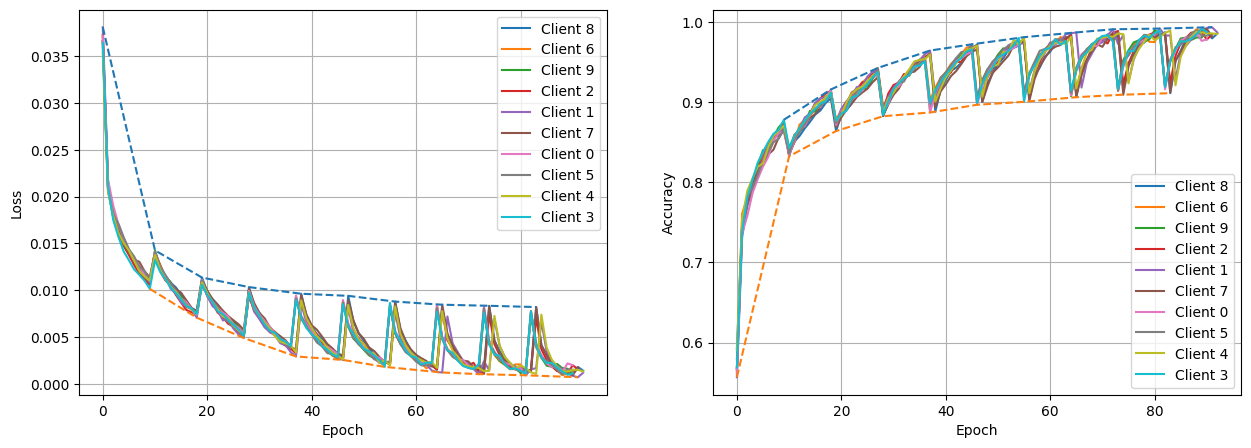

In [11]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

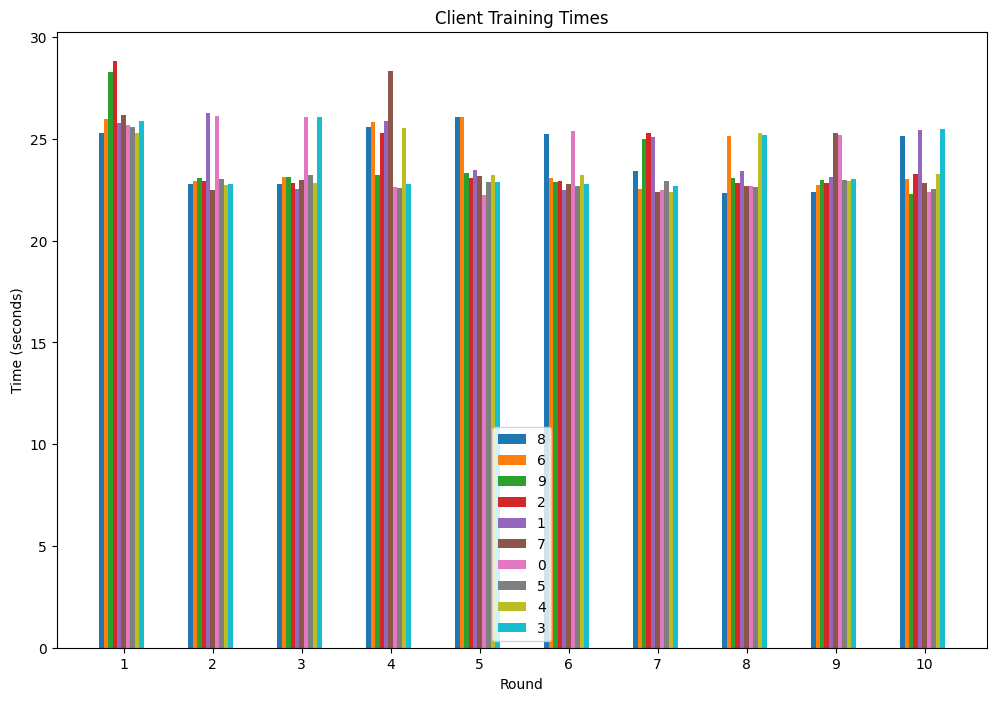

In [12]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [13]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 8 metrics: 93
Client 6 metrics: 91
Client 9 metrics: 91
Client 2 metrics: 92
Client 1 metrics: 93
Client 7 metrics: 92
Client 0 metrics: 91
Client 5 metrics: 91
Client 4 metrics: 93
Client 3 metrics: 91


In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [15]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [16]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 18:05:33,775	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 35400383692.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 72600895284.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20892) [Client 3] get_parameters
(ClientAppActor pid=20892) [Client 4] fit, config: {}
(ClientAppActor pid=20892) Epoch 0: train loss 0.035890, accuracy 0.584259
(ClientAppActor pid=34348) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=20892) Epoch 1: train loss 0.020882, accuracy 0.747222
(ClientAppActor pid=34348) Epoch 0: train loss 0.037036, accuracy 0.584630 [repeated 3x across cluster]
(ClientAppActor pid=40808) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=20892) Epoch 4: train loss 0.015801, accuracy 0.806481 [repeated 17x across cluster]
(ClientAppActor pid=34348) Epoch 4: train loss 0.016578, accuracy 0.792222 [repeated 14x across cluster]
(ClientAppActor pid=34348) Epoch 6: train loss 0.014444, accuracy 0.823519 [repeated 16x across cluster]
(ClientAppActor pid=20892) [Client 3] fit, config: {}
(ClientAppActor pid=31412) Epoch 8: train loss 0.012127, accuracy 0.857778 [repeated 15x across cluster]

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31412) [Client 4] evaluate, config: {}
(ClientAppActor pid=31412) Client 4 loss 0.01636063978075981
(ClientAppActor pid=31412) Client 4 accuracy 0.8366666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40808) [Client 9] fit, config: {}
(ClientAppActor pid=31412) Epoch 9: train loss 0.010945, accuracy 0.865926
(ClientAppActor pid=40808) Epoch 0: train loss 0.014655, accuracy 0.829444
(ClientAppActor pid=40808) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=40808) Client 2 loss 0.017614197979370753 [repeated 9x across cluster]
(ClientAppActor pid=40808) Client 2 accuracy 0.8033333333333333 [repeated 9x across cluster]
(ClientAppActor pid=15780) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=40808) Epoch 2: train loss 0.011957, accuracy 0.857593 [repeated 16x across cluster]
(ClientAppActor pid=40808) Epoch 4: train loss 0.010099, accuracy 0.879074 [repeated 16x across cluster]
(ClientAppActor pid=18884) Epoch 6: train loss 0.008633, accuracy 0.900926 [repeated 16x across cluster]
(ClientAppActor pid=34348) Epoch 8: train loss 0.007988, accuracy 0.903519 [repeated 16x across cluster]
(ClientAppActor pid=3

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34348) [Client 0] evaluate, config: {}
(ClientAppActor pid=34348) Client 0 loss 0.010635206152995428
(ClientAppActor pid=34348) Client 0 accuracy 0.8783333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20892) [Client 2] fit, config: {}
(ClientAppActor pid=34348) Epoch 9: train loss 0.006939, accuracy 0.916296 [repeated 3x across cluster]
(ClientAppActor pid=20892) [Client 3] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=20892) Client 3 loss 0.009776152987033129 [repeated 9x across cluster]
(ClientAppActor pid=20892) Client 3 accuracy 0.9016666666666666 [repeated 9x across cluster]
(ClientAppActor pid=18884) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=40808) Epoch 1: train loss 0.009252, accuracy 0.890185 [repeated 15x across cluster]
(ClientAppActor pid=31412) Epoch 3: train loss 0.008035, accuracy 0.903519 [repeated 16x across cluster]
(ClientAppActor pid=40808) Epoch 5: train loss 0.006342, accuracy 0.925370 [repeated 17x across cluster]
(ClientAppActor pid=31412) Epoch 7: train loss 0.005618, accuracy 0.931296 [repeated 16x across cluster]
(ClientAppActor pid=17892) [Client 7] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17892) [Client 7] evaluate, config: {}
(ClientAppActor pid=17892) Client 7 loss 0.011369995151956877
(ClientAppActor pid=17892) Client 7 accuracy 0.885


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35492) [Client 9] fit, config: {}
(ClientAppActor pid=31412) Epoch 0: train loss 0.009932, accuracy 0.887593 [repeated 9x across cluster]
(ClientAppActor pid=35492) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=35492) Client 6 loss 0.010872896326084932 [repeated 9x across cluster]
(ClientAppActor pid=35492) Client 6 accuracy 0.88 [repeated 9x across cluster]
(ClientAppActor pid=31412) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=40808) Epoch 2: train loss 0.006856, accuracy 0.914259 [repeated 16x across cluster]
(ClientAppActor pid=15780) Epoch 5: train loss 0.004858, accuracy 0.943519 [repeated 17x across cluster]
(ClientAppActor pid=35492) Epoch 7: train loss 0.003856, accuracy 0.957037 [repeated 17x across cluster]
(ClientAppActor pid=15780) [Client 2] fit, config: {}
(ClientAppActor pid=35492) Epoch 9: train loss 0.003337, accuracy 0.962963 [repeated 17x across cluster]
(ClientAppActor pid=20892) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=15780) [Client 0] evaluate, config: {}
(ClientAppActor pid=15780) Client 0 loss 0.010764874493082364
(ClientAppActor pid=15780) Client 0 accuracy 0.8883333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20892) [Client 0] fit, config: {}
(ClientAppActor pid=40808) Epoch 0: train loss 0.009380, accuracy 0.894815 [repeated 9x across cluster]
(ClientAppActor pid=20892) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=20892) Client 2 loss 0.013971744710579515 [repeated 9x across cluster]
(ClientAppActor pid=20892) Client 2 accuracy 0.8783333333333333 [repeated 9x across cluster]
(ClientAppActor pid=40808) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=34348) Epoch 2: train loss 0.005967, accuracy 0.923704 [repeated 15x across cluster]
(ClientAppActor pid=15780) Epoch 4: train loss 0.004295, accuracy 0.945926 [repeated 15x across cluster]
(ClientAppActor pid=34348) Epoch 6: train loss 0.002934, accuracy 0.965556 [repeated 17x across cluster]
(ClientAppActor pid=40808) Epoch 8: train loss 0.002575, accuracy 0.970926 [repeated 16x across cluster]
(ClientAppActor pid=35492) [Client 4] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17892) [Client 7] evaluate, config: {}
(ClientAppActor pid=17892) Client 7 loss 0.013393659566839536
(ClientAppActor pid=17892) Client 7 accuracy 0.89


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17892) [Client 9] fit, config: {}
(ClientAppActor pid=20892) Epoch 0: train loss 0.008270, accuracy 0.905741 [repeated 8x across cluster]
(ClientAppActor pid=35492) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=35492) Client 6 loss 0.011892084727684656 [repeated 9x across cluster]
(ClientAppActor pid=35492) Client 6 accuracy 0.8933333333333333 [repeated 9x across cluster]
(ClientAppActor pid=20892) [Client 1] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=20892) Epoch 2: train loss 0.004796, accuracy 0.942593 [repeated 16x across cluster]
(ClientAppActor pid=40808) Epoch 4: train loss 0.003520, accuracy 0.959630 [repeated 16x across cluster]
(ClientAppActor pid=20892) Epoch 6: train loss 0.002532, accuracy 0.972037 [repeated 17x across cluster]
(ClientAppActor pid=40808) Epoch 8: train loss 0.001820, accuracy 0.980000 [repeated 16x across cluster]
(ClientAppActor pid=31412) [Client 4] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31412) Epoch 9: train loss 0.001612, accuracy 0.981111 [repeated 4x across cluster]
(ClientAppActor pid=15780) [Client 4] evaluate, config: {}
(ClientAppActor pid=15780) Client 4 loss 0.013990394646922748
(ClientAppActor pid=15780) Client 4 accuracy 0.8916666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31412) [Client 6] fit, config: {}
(ClientAppActor pid=31412) Epoch 1: train loss 0.005760, accuracy 0.933333 [repeated 10x across cluster]
(ClientAppActor pid=31412) [Client 1] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=31412) Client 1 loss 0.010850325884918372 [repeated 9x across cluster]
(ClientAppActor pid=31412) Client 1 accuracy 0.8966666666666666 [repeated 9x across cluster]
(ClientAppActor pid=35492) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=31412) Epoch 3: train loss 0.003643, accuracy 0.957593 [repeated 16x across cluster]
(ClientAppActor pid=31412) Epoch 5: train loss 0.002485, accuracy 0.970000 [repeated 16x across cluster]
(ClientAppActor pid=17892) Epoch 7: train loss 0.001707, accuracy 0.981111 [repeated 17x across cluster]
(ClientAppActor pid=17892) [Client 0] fit, config: {}
(ClientAppActor pid=17892) Epoch 9: train loss 0.001564, accuracy 0.981296 [repeated 16x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31412) [Client 3] evaluate, config: {}
(ClientAppActor pid=31412) Client 3 loss 0.011117147300392389
(ClientAppActor pid=31412) Client 3 accuracy 0.9166666666666666


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35492) [Client 2] fit, config: {}
(ClientAppActor pid=18884) Epoch 0: train loss 0.007790, accuracy 0.914630 [repeated 7x across cluster]
(ClientAppActor pid=35492) [Client 9] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=35492) Client 9 loss 0.013662172816693782 [repeated 9x across cluster]
(ClientAppActor pid=35492) Client 9 accuracy 0.885 [repeated 9x across cluster]
(ClientAppActor pid=40808) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=34348) Epoch 2: train loss 0.003551, accuracy 0.959074 [repeated 15x across cluster]
(ClientAppActor pid=18884) Epoch 4: train loss 0.002082, accuracy 0.975370 [repeated 16x across cluster]
(ClientAppActor pid=18884) Epoch 6: train loss 0.001533, accuracy 0.984074 [repeated 15x across cluster]
(ClientAppActor pid=15780) Epoch 8: train loss 0.001134, accuracy 0.988148 [repeated 17x across cluster]
(ClientAppActor pid=35492) [Client 8] fit, config: {}
(ClientAppActor pid=35492)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35492) [Client 4] evaluate, config: {}
(ClientAppActor pid=35492) Client 4 loss 0.016105736276755732
(ClientAppActor pid=35492) Client 4 accuracy 0.8916666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31412) [Client 7] fit, config: {}
(ClientAppActor pid=35492) Epoch 9: train loss 0.001190, accuracy 0.987778 [repeated 3x across cluster]
(ClientAppActor pid=35492) [Client 5] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=31412) Client 2 loss 0.01803521454334259 [repeated 9x across cluster]
(ClientAppActor pid=31412) Client 2 accuracy 0.8883333333333333 [repeated 9x across cluster]
(ClientAppActor pid=17892) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=35492) Epoch 1: train loss 0.004078, accuracy 0.950741 [repeated 10x across cluster]
(ClientAppActor pid=35492) Epoch 3: train loss 0.002189, accuracy 0.974259 [repeated 17x across cluster]
(ClientAppActor pid=31412) Epoch 5: train loss 0.001641, accuracy 0.981481 [repeated 15x across cluster]
(ClientAppActor pid=17892) Epoch 7: train loss 0.002046, accuracy 0.978889 [repeated 17x across cluster]
(ClientAppActor pid=31412) [Client 2] fit, config: {}
(ClientAppActo

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=34348) Epoch 9: train loss 0.001414, accuracy 0.984444 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31412) [Client 7] evaluate, config: {}
(ClientAppActor pid=31412) Client 7 loss 0.015211550245682399
(ClientAppActor pid=31412) Client 7 accuracy 0.8966666666666666


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34348) [Client 3] fit, config: {}
(ClientAppActor pid=34348) Epoch 1: train loss 0.003728, accuracy 0.950926 [repeated 10x across cluster]
(ClientAppActor pid=34348) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=34348) Client 6 loss 0.013788680210709572 [repeated 9x across cluster]
(ClientAppActor pid=34348) Client 6 accuracy 0.9016666666666666 [repeated 9x across cluster]
(ClientAppActor pid=18884) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=20892) Epoch 3: train loss 0.001710, accuracy 0.983333 [repeated 17x across cluster]
(ClientAppActor pid=20892) Epoch 5: train loss 0.001495, accuracy 0.982222 [repeated 16x across cluster]
(ClientAppActor pid=20892) Epoch 7: train loss 0.001119, accuracy 0.987407 [repeated 16x across cluster]
(ClientAppActor pid=34348) [Client 2] fit, config: {}
(ClientAppActor pid=20892) Epoch 9: train loss 0.001030, accuracy 0.989259 [repeated 16x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20892) [Client 2] evaluate, config: {}
(ClientAppActor pid=20892) Client 2 loss 0.019518869357804457
(ClientAppActor pid=20892) Client 2 accuracy 0.895


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 558.08s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.01687309197584788
INFO :      		round 2: 0.011650273059184353
INFO :      		round 3: 0.011498065184801818
INFO :      		round 4: 0.01184410738805309
INFO :      		round 5: 0.012637887818738818
INFO :      		round 6: 0.013150840158574283
INFO :      		round 7: 0.014168628932908177
INFO :      		round 8: 0.014798261566708484
INFO :      		round 9: 0.015020313472487033
INFO :      		round 10: 0.01610842189968874
INFO :      


History (loss, distributed):
	round 1: 0.01687309197584788
	round 2: 0.011650273059184353
	round 3: 0.011498065184801818
	round 4: 0.01184410738805309
	round 5: 0.012637887818738818
	round 6: 0.013150840158574283
	round 7: 0.014168628932908177
	round 8: 0.014798261566708484
	round 9: 0.015020313472487033
	round 10: 0.01610842189968874

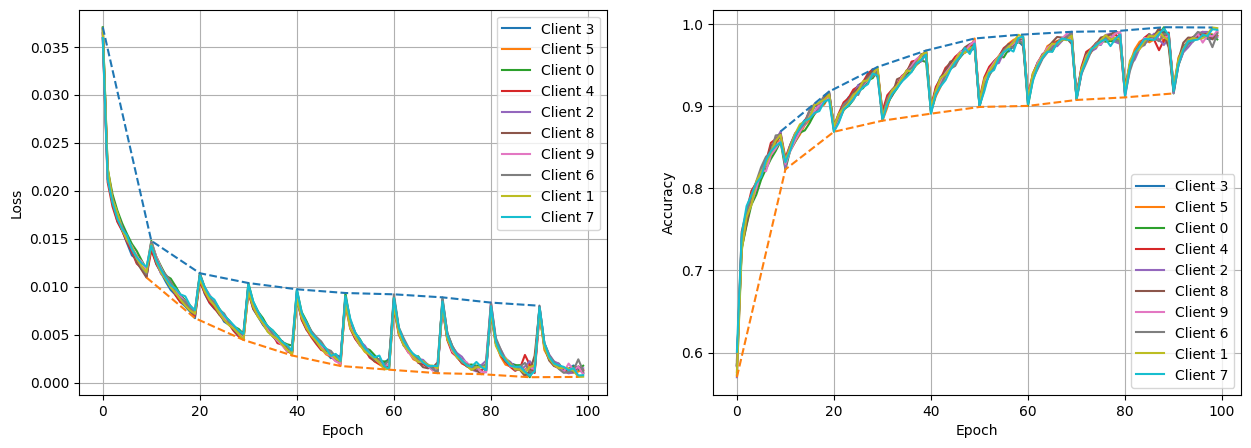

In [17]:
plot_metrics(strategy_fed_avg.client_metrics)

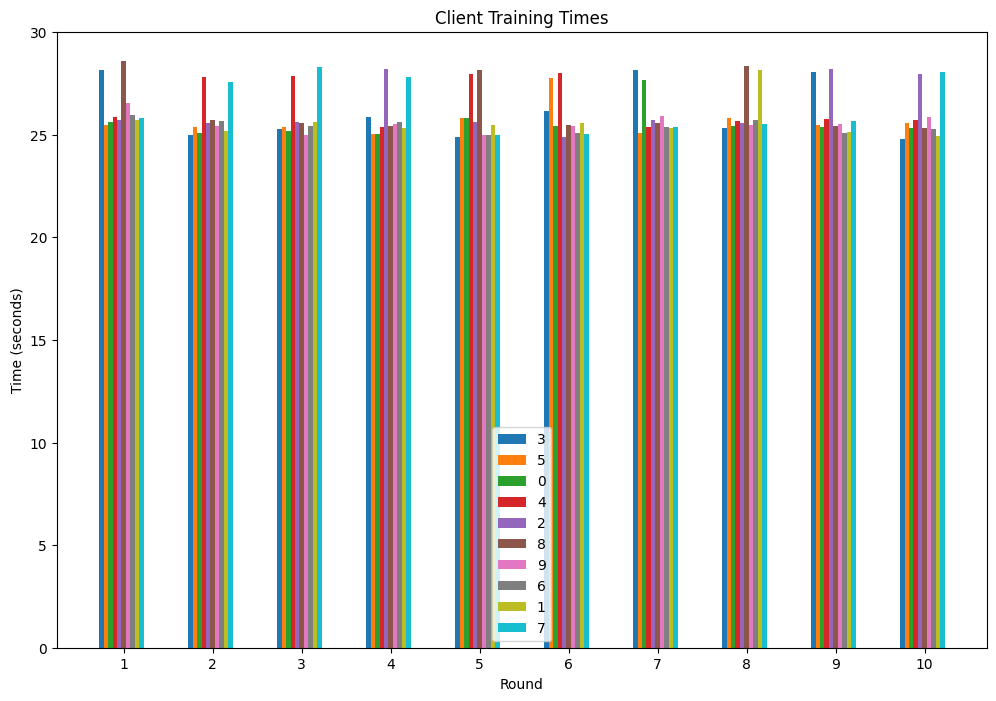

In [18]:
plot_times(strategy_fed_avg.client_training_times)